# MNIST Handwritten Digit Generation using DCGAN

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('Running TF without GPU')
else:
    print(f'Found GPU at {device_name}')

Running TF without GPU


In [2]:
%matplotlib inline

import os
import seaborn as sn

from abc import abstractstaticmethod
from matplotlib import pyplot as plt
from tensorflow import keras

sn.set_theme()

## DCGAN Architecture

Source: https://arxiv.org/

In [3]:
NOISE_DIMENSION = 128
TRAIN_SIZE = 60000
TEST_SIZE = 10000
BATCH_SIZE = 64
EPOCHS = 20

EPSILON = 1e-7
N_EXAMPLES = 25
G_LEARNING_RATE = 1e-4
D_LEARNING_RATE = 1e-4

ARCH = 'dcgan'

IN_COLAB = False
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_prefix = ''

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    path_prefix = '/content/drive/My Drive/gan-vae/gan'
    
METRICS_PATH = f'{path_prefix}/metrics/{ARCH}/'
OUTPUT_PATH = f'{path_prefix}/output/{ARCH}/'

!mkdir -p $METRICS_PATH
!mkdir -p $OUTPUT_PATH

assert NOISE_DIMENSION > 0
assert TRAIN_SIZE <= 600000
assert BATCH_SIZE >= 1
assert EPOCHS >= 1
assert EPSILON > 0
assert N_EXAMPLES >= 1
assert G_LEARNING_RATE > 0
assert D_LEARNING_RATE > 0

## Base Class

In [4]:
class BaseNetwork(tf.Module):
    def __init__(self):
        super().__init__()

    @tf.Module.with_name_scope
    def __call__(self, input_data, training=False) -> tf.Tensor:
        output_data = input_data
        for layer in self.layers:
            output_data = layer(output_data, training=training)
        return output_data

    @abstractstaticmethod
    def loss() -> tf.Tensor:
        raise NotImplementedError

    @abstractstaticmethod
    def optimizer(*args, **kwargs) -> tf.optimizers.Optimizer:
        raise NotImplementedError

## Generator Network
### Layers
<pre>
Input:         input_size=(128, 1)
Deconvolution:
</pre>

### Optimizer
<pre>
Adam:          learning_rate=0.0002
</pre>

### Loss
&#8466;<sub>G</sub>(<i><b>z</b></i>) = <sup>-1</sup>&frasl;<sub>m</sub> &lowast; &sum;<sub><i>i</i></sub> log(<i>D</i>(G(<i><b>z</b><sup>(i)</sup></i>)))

### Goal
Find argmin<sub>G</sub> {&#8466;<sub>G</sub>(<i><b>z</b></i>)}

In [5]:
class Generator(BaseNetwork):
    def __init__(self, noise_dimension: int, output_shape: tuple) -> None:
        super().__init__()
        # Network layers
        self.layers = [
            keras.layers.InputLayer(input_shape=(noise_dimension,)),
            keras.layers.Dense(units=7*7*256),
            keras.layers.BatchNormalization(),
            keras.layers.Reshape(target_shape=(7, 7, 256)),
            keras.layers.LeakyReLU(),
            keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU(),
            keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU(),
            keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(2, 2), padding='same'),
            keras.layers.Activation(tf.nn.tanh),
        ]

    @staticmethod
    def optimizer(learning_rate: float, momentum: float=0.0) -> tf.optimizers.Optimizer:
        return tf.optimizers.Adam(learning_rate=learning_rate)

    @staticmethod
    @tf.function
    def loss(generated_output):
        loss_i = tf.math.log(generated_output+EPSILON)
        loss = -tf.math.reduce_mean(loss_i)
        return loss

## Discriminator Network
### Layers
<pre>
<b>Input</b>:        input_size=(28, 28, 1)
<b>Convolution</b>:  filters=32, kernel_size=(3, 3), strides=(1, 1), activation=ReLU
<b>Max Pooling</b>:  pool_size=(2, 2)
<b>Convolution</b>:  filters=64, kernel_size=(3, 3), strides=(1, 1), activation=ReLU
<b>Max Pooling</b>:  pool_size=(2, 2)
<b>Dense</b>:        units=512, activation=ReLU
<b>Dropout</b>:      rate=0.3
<b>Dense</b>:        units=256, activation=ReLU
<b>Dropout</b>:      rate=0.2
<b>Dense</b>:        units=1, activation=tanh
</pre>

### Optimizer
<pre>
<b>Adam</b>:         learning_rate=0.0002
</pre>

### Loss
&#8466;<sub>D</sub>(<i><b>x</b>,<b>z</b>) = <sup>-1</sup>&frasl;<sub>m</sub> &lowast; &sum;<i><sub>i</sub></i> \[log <i>D</i>(<i><b>x</b><sup>(i)</sup></i>) + log (1-<i>D</i>(G(<i><b>z</b><sup>(i)</sup></i>)))\]

### Goal
Find argmin<sub>D</sub> &#8466;<sub>D</sub>(<i><b>x</b></i>,<i><b>z</b></i>)

In [14]:
class Discriminator(BaseNetwork):
    def __init__(self, input_shape: tuple) -> None:
        super().__init__()
        # Network layers
        self.layers = [
            keras.layers.InputLayer(input_shape=input_shape),
            keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2)),
            keras.layers.LeakyReLU(),
            keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2)),
            keras.layers.LeakyReLU(),
            keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2)),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(rate=0.2),
            keras.layers.Flatten(),
            keras.layers.Dense(units=64),
            keras.layers.Dropout(rate=0.1),
            keras.layers.Dense(units=1),
            keras.layers.Activation(tf.nn.sigmoid)
        ]

    @staticmethod
    def optimizer(learning_rate: float, momentum: float=0.0):
        return tf.optimizers.Adam(learning_rate=learning_rate)

    @staticmethod
    @tf.function
    def loss(trained_ouput, generated_output) -> tf.Tensor:
        loss_i = tf.math.log(trained_ouput+EPSILON) + tf.math.log1p(EPSILON-generated_output)
        loss = -tf.math.reduce_mean(loss_i)
        return loss

## Preprocessing
* Import MNIST training images
* Normalize to \[-1, 1\]
* Shuffle and batch dataset

In [15]:
(train_images, _), (test_images, _) = keras.datasets.mnist.load_data()

train_images = tf.dtypes.cast((train_images[:TRAIN_SIZE]-127.5) / 127.5, tf.float32)
train_images = tf.expand_dims(input=train_images, axis=-1)
train_ds = tf.data.Dataset.from_tensor_slices(train_images) \
                          .shuffle(TRAIN_SIZE) \
                          .batch(BATCH_SIZE)

test_images = tf.dtypes.cast((train_images[:TEST_SIZE]-127.5) / 127.5, tf.float32)

### Initialize Generator and Discriminator
* Generator takes in 128-dimensional Gaussian sample, and outputs an image.
* Discriminator takes in images, and outputs whether it is classified as data from the training distribution or generator distribution

In [16]:
generator = Generator(noise_dimension=NOISE_DIMENSION, output_shape=(train_images.shape[1:]))
generator_optimizer = generator.optimizer(G_LEARNING_RATE)

discriminator = Discriminator(input_shape=(train_images.shape[1:]))
discriminator_optimizer = discriminator.optimizer(D_LEARNING_RATE)

In [17]:
fixed_noise = tf.random.normal([N_EXAMPLES, NOISE_DIMENSION])
metrics_names = ['g_loss', 'd_loss', 'acc', 'real_acc', 'fake_acc']
batch_history = { name: [] for name in metrics_names }
epoch_history = { name: [] for name in metrics_names }

In [18]:
def record_sample(generator: Generator, epoch: int, test_input: tf.Tensor, save: bool=True, show=True):
    predictions = generator(test_input, training=False)

    plt.figure(figsize=(8, 8))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i]*127.5 + 127.5, cmap=plt.cm.gray)
        plt.axis('off')

    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, 'epoch_{:04d}.png'.format(epoch)))
    if show:
        plt.show()
    plt.close()

### Accuracy

In [19]:
def accuracy(trained_output, generated_output) -> tuple:
    # Trained images fed into D have output 1, images from G's noisy
    # distribution should have output 0 from D
    correct_trained_output = tf.ones_like(trained_output)
    correct_generated_ouput = tf.zeros_like(generated_output)

    real_acc = tf.math.reduce_mean(tf.dtypes.cast(tf.math.equal(tf.math.round(trained_output), correct_trained_output), tf.float32))
    fake_acc = tf.math.reduce_mean(tf.dtypes.cast(tf.math.equal(tf.math.round(generated_output), correct_generated_ouput), tf.float32))

    return real_acc, fake_acc

## GAN Algorithm
<pre>
<b>for</b> number of training iterations <b>do</b>
  <b>for</b> k steps <b>do</b>
     • Sample minibatch of <i>m</i> noise samples {<i><b>z</b><sup>(1)</sup>, ..., <b>z</b><sup>(m)</sup></i>} from noise prior <i>p<sub>g</sub>(<b>z</b>)</i>.
     • Sample minibatch of <i>m</i> examples {<i><b>x</b><sup>(1)</sup>, ..., <b>x</b><sup>(m)</sup></i>} from data generating distribution <i>p<sub>data</sub>(<b>x</b>)</i>.
     • Update the discriminator by <u>ascending</u> its stochastic gradient:
       <center>&Del;<sub>&theta;<sub>d</sub></sub> <sup>1</sup>&frasl;<sub>m</sub> &lowast; &sum;<sub><i>i</i></sub> [log <i>D</i>(<i><b>x</b><sup>(i)</sup></i>) + log(1-<i>D</i>(G(<i><b>z</b><sup>(i)</sup></i>)))]</center>
  <b>end for</b>
  • Sample minibatch of <i>m</i> noise samples {<i><b>z</b><sup>(1)</sup>, ..., <b>z</b><sup>(m)</sup></i>} from noise prior <i>p<sub>g</sub>(<b>z</b>)</i>.
  • Update the generator by <u>descending</u> its stochastic gradient:
  <center>&Del;<sub>&theta;<sub>d</sub></sub> <sup>1</sup>&frasl;<sub>m</sub> &lowast; &sum;<sub><i>i</i></sub> log(1-<i>D</i>(G(<i><b>z</b><sup>(i)</sup></i>)))</center>
<b>end for</b>
</pre>

Source: https://arxiv.org/pdf/1406.2661.pdf

In [20]:
# view_sample(generator, 1, fixed_noise)
steps_per_epoch = train_images.shape[0] // BATCH_SIZE

for epoch in range(1, EPOCHS+1):
    print(f'\nepoch {epoch}/{EPOCHS}')
    progress_bar = keras.utils.Progbar(steps_per_epoch, stateful_metrics=metrics_names)

    for i, image_batch in enumerate(train_ds):

        num_samples = image_batch.shape[0]
        noise = tf.random.normal([num_samples, NOISE_DIMENSION])

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            # Train G on noise
            generated_images = generator(noise, training=True)
            # Train D on training images
            trained_output = discriminator(image_batch, training=True)
            # Train D on generated images
            generated_output = discriminator(generated_images, training=True)

            # Calculate loss
            g_loss = generator.loss(generated_output)
            d_loss = discriminator.loss(trained_output, generated_output)

        real_acc, fake_acc = accuracy(trained_output, generated_output)
        acc = 0.5 * (real_acc + fake_acc)

        updated_metrics = {
            'g_loss': g_loss,
            'd_loss': d_loss,
            'acc': acc,
            'real_acc': real_acc,
            'fake_acc': fake_acc,
        }

        # Record loss history
        for metric in batch_history:
            batch_history[metric].append(updated_metrics[metric])
    
        metric_values = updated_metrics.items()
        progress_bar.update(min(i, steps_per_epoch), values=metric_values)        

        # https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient
        grad_g = g_tape.gradient(g_loss, generator.trainable_variables)
        grad_d = d_tape.gradient(d_loss, discriminator.trainable_variables)

        # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer#apply_gradients
        generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))    

    record_sample(generator, epoch, fixed_noise, show=False)


epoch 1/20
937/937 [==============================] - 229s 245ms/step - g_loss: 1.3229 - d_loss: 0.7571 - acc: 0.8906 - real_acc: 0.8750 - fake_acc: 0.9062

epoch 2/20
937/937 [==============================] - 231s 246ms/step - g_loss: 1.5050 - d_loss: 0.9664 - acc: 0.7031 - real_acc: 0.6562 - fake_acc: 0.7500

epoch 3/20
937/937 [==============================] - 269s 287ms/step - g_loss: 1.6264 - d_loss: 0.9143 - acc: 0.7812 - real_acc: 0.7812 - fake_acc: 0.7812

epoch 4/20
579/937 [=================>............] - ETA: 1:34 - g_loss: 1.7301 - d_loss: 0.7459 - acc: 0.8281 - real_acc: 0.8438 - fake_acc: 0.8125

KeyboardInterrupt: 

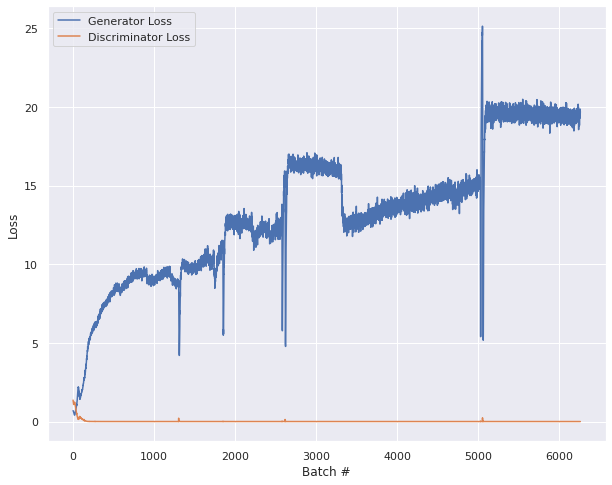

In [232]:
plt.figure(figsize=(10, 8))
plt.plot(batch_history['g_loss'], label='Generator Loss')
plt.plot(batch_history['d_loss'], label='Discriminator Loss')
plt.xlabel('Batch #')
plt.ylabel('Loss')
plt.title('DCGAN Loss')
plt.legend()
plt.savefig(os.path.join(METRICS_PATH, 'loss.png'))
plt.show()
plt.close()

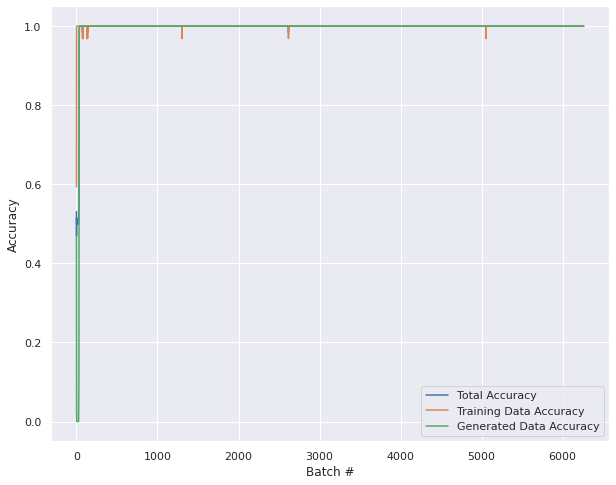

In [233]:
plt.figure(figsize=(10, 8))
plt.plot(batch_history['acc'], label='Total Accuracy')
plt.plot(batch_history['real_acc'], label='Training Data Accuracy')
plt.plot(batch_history['fake_acc'], label='Generated Data Accuracy')
plt.xlabel('Batch #')
plt.ylabel('Accuracy')
plt.title('DCGAN Accuracy')
plt.legend()
plt.savefig(os.path.join(METRICS_PATH, 'accuracy.png'))
plt.show()
plt.close()

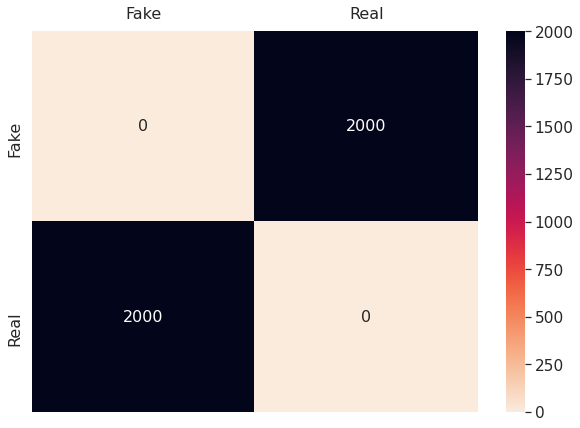

In [235]:
real_test_preds = tf.dtypes.cast(tf.math.round(discriminator(test_images, training=False)), tf.float32)
fake_test_preds = tf.dtypes.cast(tf.math.round(discriminator(tf.random.normal(test_images.shape), training=False)), tf.float32)
real_labels = tf.ones_like(real_test_preds)
fake_labels = tf.zeros_like(fake_test_preds)
preds = tf.concat([real_test_preds, fake_test_preds], axis=0)
labels = tf.concat([real_labels, fake_labels], axis=0)
preds = tf.squeeze(preds)
labels = tf.squeeze(labels)
named_labels = ['Fake', 'Real']
confusion_matrix = tf.math.confusion_matrix(labels, preds, num_classes=2).numpy()
plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)
ax = sn.heatmap(confusion_matrix, annot=True, annot_kws={'size': 16}, fmt='d', cmap=sn.cm.rocket_r, xticklabels=named_labels, yticklabels=named_labels)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.tick_params(axis='both', which='major', labelsize=16, labelbottom=False, bottom=False, top=False, labeltop=True)
plt.savefig(os.path.join(METRICS_PATH, 'confusion_matrix.png'))
plt.show()
plt.close()

In [ ]:
for _ in range(5):
    real_test_image = test_images[tf.random.uniform(shape=(), minval=0, maxval=TEST_SIZE+1, dtype=tf.int32)]
    fake_test_image_1 = generator(tf.random.normal([1, 100]), training=False)
    fake_test_image_2 = tf.nn.tanh(tf.random.normal(train_images.shape[1:]))

    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(real_test_image, cmap=plt.cm.gray)
    ax1.axis('off')
    real_test_image = tf.expand_dims(input=real_test_image, axis=0)
    ax1.set_title(tf.math.round(discriminator(real_test_image, training=False)).numpy()[0][0])

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(fake_test_image_1[0, :, :, 0], cmap=plt.cm.gray)
    ax2.axis('off')
    ax2.set_title(tf.math.round(discriminator(fake_test_image_1, training=False)).numpy()[0][0])

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(fake_test_image_2, cmap=plt.cm.gray)
    ax3.axis('off')
    fake_test_image_2 = tf.expand_dims(input=fake_test_image_2, axis=0)
    ax3.set_title(tf.math.round(discriminator(fake_test_image_1, training=False)).numpy()[0][0])

    plt.show()
    plt.close()